In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import scipy
%matplotlib inline
import numpy as np

Esse notebook tem o objetivo de comparar os resultados obtidos para 100 indivíduos, 300 gerações, P_cross=0.6, P_mut=0.3, base concrete com e sem elitismo.

# 1 - Fitness média ao longo das gerações

In [7]:
results_folder_path = pathlib.Path('../../results/')

In [15]:
def get_fitness_data_per_config(folders_paths) -> list[dict]:
    data_per_config = dict()
    for target_folder in folders_paths:
        fitness_stats_path = target_folder / 'fitness_stats.csv'
        print(fitness_stats_path)
        stats_df = pd.read_csv(fitness_stats_path)
        folder_name_splitted = str(target_folder).split('/')[-1].split('_')
        if len(folder_name_splitted) <= 5:
            config_name = 'elitism'
        else:
            config_name = 'no_elitism'
        
        data_per_config[config_name] = stats_df
    return data_per_config

In [16]:
results_folders = list(results_folder_path.glob('concrete/100pop_300gen_tour_*'))
data_per_selection = get_fitness_data_per_config(results_folders)

../../results/concrete/100pop_300gen_tour_pc_pm_no_elitism/fitness_stats.csv
../../results/concrete/100pop_300gen_tour_pc_pm/fitness_stats.csv


In [17]:
def plot_fitness_results(data_dict, num_runs=30, base_dados='concrete'):
    train_data_colors = {'elitism':'red', 
                     'no_elitism':'green'}

    test_data_colors = {'elitism':'orange', 
                     'no_elitism':'cyan'}

    x = range(num_runs)
    fig, ax = plt.subplots(figsize=(9, 6))
    for config, data in data_dict.items():
            ax.plot(x, data['train_fit'], color=train_data_colors[config], label=config+" train")
            ax.plot(x, data['test_fit'], color=test_data_colors[config], label=config+" test")

    plt.title(f"Melhor Fitness treino e teste base {base_dados}")
    plt.xlabel("Execução")
    plt.ylabel("Fitness")
    plt.legend()
    return ax

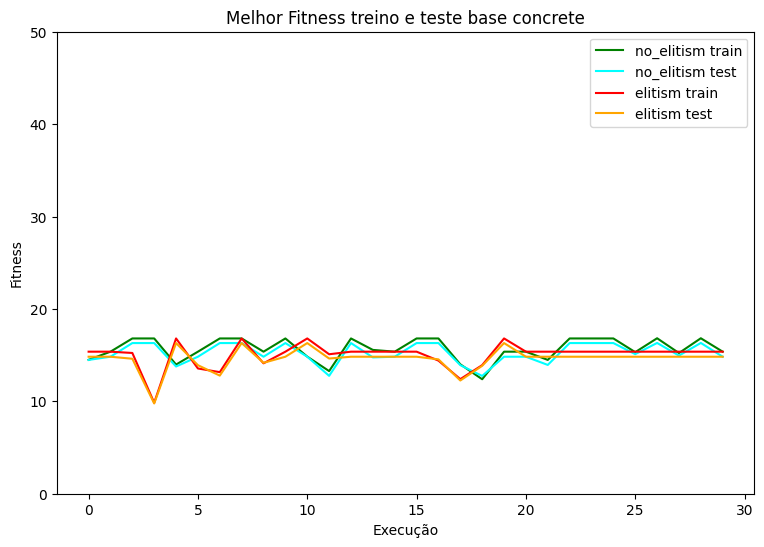

In [18]:
ax = plot_fitness_results(data_per_selection)
ax.set_ylim((0, 50))
plt.show()

In [19]:
def get_trimmed_mean_train_test_fitness(data_dict, trim=0.05)-> dict[str, dict]:
    config_dict_results = dict()
    for config, data in data_dict.items():
        config_dict_results[config] = dict()
        config_dict_results[config]['train'] = scipy.stats.trim_mean(data.train_fit, trim)
        config_dict_results[config]['test'] = scipy.stats.trim_mean(data.test_fit, trim)
    return config_dict_results

In [20]:
mean_fit_results = get_trimmed_mean_train_test_fitness(data_per_selection)
mean_fit_results

{'no_elitism': {'train': 15.730814862684026, 'test': 15.283689294523514},
 'elitism': {'train': 15.129464646315474, 'test': 14.703443354792482}}

In [24]:
simple_stats_dict = [mean_fit_results[config] for config in mean_fit_results.keys()]
results_df = pd.DataFrame.from_records(simple_stats_dict)
results_df.index = ['no_elitism', 'elitism']

In [25]:
results_df

,train,test
no_elitism,15.730815,15.283689
elitism,15.129465,14.703443


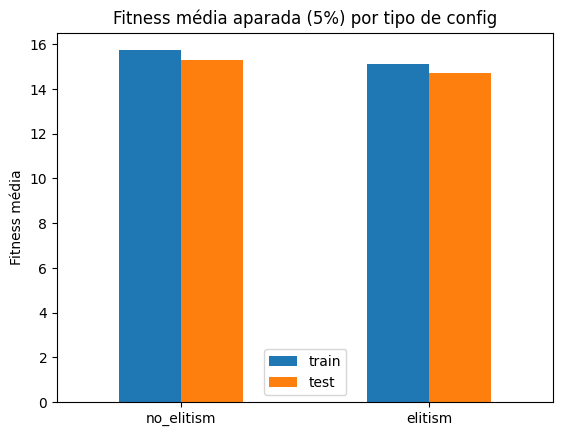

In [26]:
results_df.plot(kind='bar')
plt.title("Fitness média aparada (5%) por tipo de config")
plt.ylabel("Fitness média")
plt.xticks(rotation=0)
plt.show()

# 2 - Best fitness ao longo das gerações

In [27]:
def get_300_gen_stats_df_dict_by_run_of_folder(folder):
    files = list(folder.glob("stats*"))
    stats_dict = dict()
    for file in files:
        file_num = str(file).split('_')[-1].split('.')[0]
        stats_dict[int(file_num)] = pd.read_csv(file)
    return stats_dict

In [28]:
results_folders

[PosixPath('../../results/concrete/100pop_300gen_tour_pc_pm_no_elitism'),
 PosixPath('../../results/concrete/100pop_300gen_tour_pc_pm')]

In [30]:
elitism_dfs = get_300_gen_stats_df_dict_by_run_of_folder(results_folders[1])
no_elitism_dfs = get_300_gen_stats_df_dict_by_run_of_folder(results_folders[0])

In [33]:
def get_line_and_col_of_runs(df_dict, target_line, target_cols:list):
    results_list_of_dicts = list()
    for df_num, df in df_dict.items():
        results_list_of_dicts.append(df.iloc[target_line][target_cols].to_dict())
    
    return pd.DataFrame(results_list_of_dicts)
def get_col_stats_from_dfs_dict(df_dict, target_col):
    records_list = list()
    for gen in range(300):
        curr_values = get_line_and_col_of_runs(df_dict, gen, [target_col]).values.flatten()
        min_value = np.min(curr_values)
        max_value = np.max(curr_values)
        mean_value = np.mean(curr_values)
        new_record = {'min_value':min_value, 'max_value':max_value, 'mean_value':mean_value}
        records_list.append(new_record)

    return pd.DataFrame.from_records(records_list)

In [34]:
best_fit_elitism_df = get_col_stats_from_dfs_dict(elitism_dfs, 'best_fit')
best_fit_no_elitism_df = get_col_stats_from_dfs_dict(no_elitism_dfs, 'best_fit')

In [35]:
def plot_fill_between(stats_df, my_axs, label:str):
    x = range(len(stats_df))
    y = stats_df['mean_value']
    y1 = stats_df['min_value']
    y2 = stats_df['max_value']
    my_axs.plot(x, y, '-', label=label)
    my_axs.fill_between(x, y1, y2, alpha=0.2)

Text(0.5, 1.0, 'Melhor fitness média para 30 runs e 100 indivíduos')

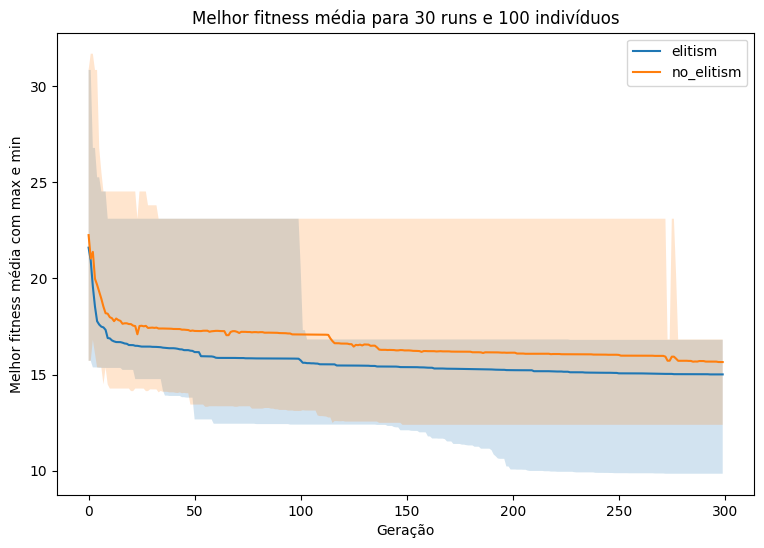

In [37]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_fill_between(best_fit_elitism_df, ax, 'elitism')
plot_fill_between(best_fit_no_elitism_df, ax, 'no_elitism')

ax.legend()
ax.set_ylabel("Melhor fitness média com max e min")
ax.set_xlabel("Geração")
ax.set_title("Melhor fitness média para 30 runs e 100 indivíduos")